In [132]:
%matplotlib ipympl
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import IntSlider, Output
from itertools import product
from scipy.signal import find_peaks
import math
from mpl_toolkits.mplot3d import Axes3D

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools

In [133]:
# %autoreload 2
# %load_ext autoreload

In [134]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)

In [136]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [137]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof = wd.dataset_tdc_selection()
display(tdc, det_diam, pulse_mode, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

FloatText(value=78.0, description='Detector diameter:')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=51.74, description='t0:')

$$\textbf{You can specify which dataset to use in below block}$$

In [138]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

flightPathLength = flightPathLength_d.value # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()
# variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.dirname(dataset_main_path) +  '/tof_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

if tdc_model == 'leap_pos' or tdc_model == 'leap_pos':
    if tdc_model == 'leap_epos':
        data = ccapt_tools.epos_to_ccapt(filename)
    else:
        print('The file has to be epos. With pos information this tutorial cannot be run')
        data = ccapt_tools.pos_to_ccapt(filename)
else:
    data = data_tools.read_hdf5_through_pandas(filename)


In [139]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,59.590457,3154.404053,3154.404053,51225.0,1146.088386,0.0,0.203755,-1.079265,0,1
1,0.0,0.0,0.0,0.0,60.230824,3154.404053,3154.404053,51305.0,1149.435090,0.0,-0.095510,-0.799102,80,1
2,0.0,0.0,0.0,0.0,60.591436,3154.404053,3154.404053,51399.0,1158.371064,0.0,-0.012735,-1.378531,94,1
3,0.0,0.0,0.0,0.0,62.235298,3154.404053,3154.404053,51448.0,1190.768256,0.0,1.177959,2.091673,49,1
4,0.0,0.0,0.0,0.0,61.049516,3154.404053,3154.404053,51455.0,1178.602164,0.0,0.897796,2.161714,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682356,0.0,0.0,0.0,0.0,61.973033,5310.980957,5310.980957,55949.0,912.518622,0.0,-0.646286,-0.993306,435,1
1682357,0.0,0.0,0.0,0.0,61.505565,5310.980957,5310.980957,56135.0,935.582076,0.0,-3.005388,-0.006367,186,1
1682358,0.0,0.0,0.0,0.0,62.860240,5310.980957,5310.980957,56565.0,926.783262,0.0,-1.846531,0.547592,430,1
1682359,0.0,0.0,0.0,0.0,61.160990,5310.980957,5310.980957,57092.0,926.193474,0.0,2.317714,-1.276653,527,1


In [140]:
# Remove negative TOF
# threshold = 0
# dld_t_mask = data['t (ns)'].to_numpy()
# dld_t_mask = (dld_t <= threshold)
# data.drop(np.where(dld_t_mask)[0], inplace=True)
# data.reset_index(inplace=True, drop=True)


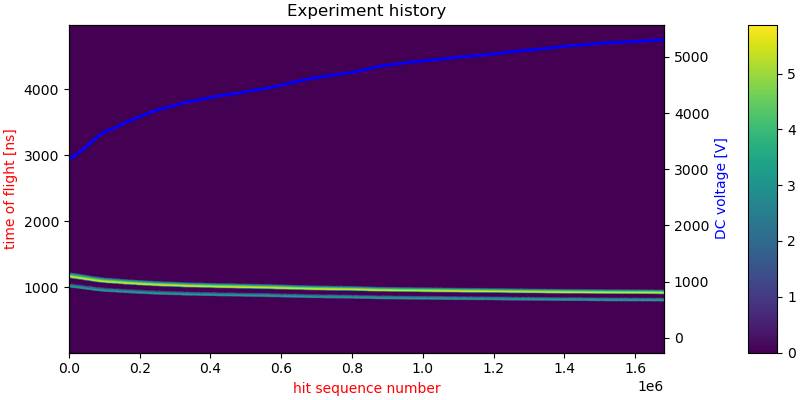

In [141]:
data_loadcrop.plot_crop_experimetn_history(data, save_name=variables.result_path + '//ex_hist_' + dataset_name)


In [142]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x_det (cm)'].to_numpy()
dld_y = data['y_det (cm)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)
variables.dld_t_calib_backup = np.copy(dld_t)

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

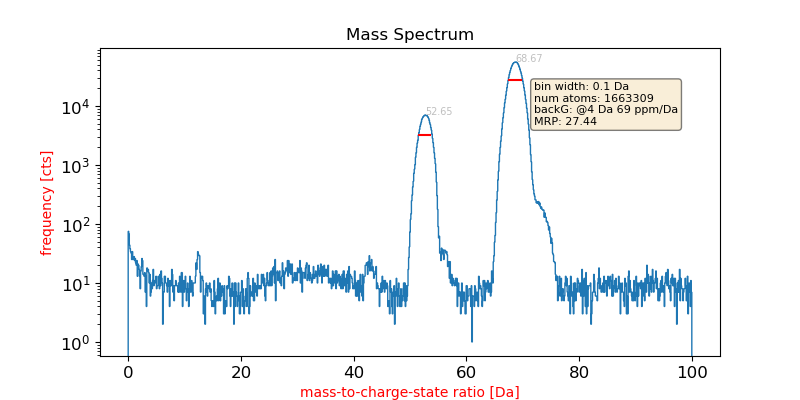

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 27.441576249811135
Peaks  0 is at location and height: (52.65, 7036.00) peak window sides (50.00%) are: (51.45, 53.75)
Peaks  1 is at location and height: (68.67, 55546.00) peak window sides (50.00%) are: (67.37, 69.87)


In [143]:
percent_mrp = 50
lim = 100
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode=pulse_mode_ini)
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc_seb_ini[mc_seb_ini < lim], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [144]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=500, description='peak distance:')
lim_tof=widgets.IntText(value=1500, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')

def hist_plot(figname, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        selector = 'rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_tof_p], bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p, selector=selector, plot=plot, label='tof', fig_name=figname)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
            print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [145]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, figname=figname):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value
        if plot_p:
            clear_output(True)

        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, det_diam.value, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p)


In [146]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='sample mode:'
)
def vol_correction(dld_highVoltage, figname):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        if plot_p:
            clear_output(True)
        calibration.voltage_corr_main(dld_highVoltage, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p)


In [147]:
pb_bowl = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
pb_vol = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_button = widgets.Button(
    description='reset back correction',
)
save_button = widgets.Button(
    description='save correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')
    
@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, save=True):
    with out:
        clear_output(True)
        mask_temporal = np.logical_and((variables.dld_t_calib > variables.selected_x1),
                                       (variables.dld_t_calib < variables.selected_x2))
        x = dld_x[mask_temporal]
        y = dld_y[mask_temporal]
        bin_fdm_p = bin_fdm.value
        bins = [bin_fdm_p, bin_fdm_p]

        calibration.plot_FDM(x, y, save, bins)
    
@reset_button.on_click
def reset_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib = np.copy(variables.dld_t_calib_backup)
@save_button.on_click
def save_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)
    
@bowl_button.on_click
def bowl_on_click(b, dld_x=dld_x, dld_y=dld_y, dld_highVoltage=dld_highVoltage, figname=figname):
    pb_bowl.value = "<b>Starting...</b>"
    bowl_correction(dld_x, dld_y, dld_highVoltage, figname)  
    pb_bowl.value = "<b>Flished</b>"
@vol_button.on_click
def vol_on_click(b, dld_highVoltage=dld_highVoltage, figname=figname):
    pb_vol.value = "<b>Starting...</b>"
    vol_correction(dld_highVoltage, figname)
    pb_vol.value = "<b>Flished</b>"
    


tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, plot_b, save_b]), bowl_button, pb_bowl])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, plot_v, save_v]), vol_button, pb_vol])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, save_button, reset_button])]))
out = Output()
display(out)

Output()

In [27]:
variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)

In [117]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_dld_t):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='tof', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
                   print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [118]:
interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_dld_t=widgets.IntText(value=1500)
               ,percent=widgets.IntText(value=50), selector=fixed('peak'), plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [115]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), "{}({})[{}]".format(element[0], element[1], element[2]))
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b,)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        wd.onClickDelete(b,)
        display()
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b,)
        display()

listMaterial = buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)
# listMaterial = buttonAdd.on_click(wd.onClickAdd)
# buttonDelete.on_click(wd.onClickDelete)
# buttonReset.on_click(wd.onClickReset)
out = Output()
display(out)

Dropdown(description='Elements', options=(('H (1) (99.98)', 'H(1)[1.01]'), ('H (2) (0.01)', 'H(2)[2.01]'), ('H…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

Output()

In [119]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(variables.peak[variables.peaks_idx[i]])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: [212.18595241 528.96059933 716.45775133]
highest peak in the ideal mc histogram: [ 1.01 13.49 26.98]


In [120]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal, maxfev=2000, bounds=(0, [100., 10., 10.0]))
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


mc_p_1 = parametric(variables.dld_t_calib, *fitresult)

C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [121]:
print('The t0 is:', fitresult[0], 'ns')

The t0 is: 82.68963425628858 ns


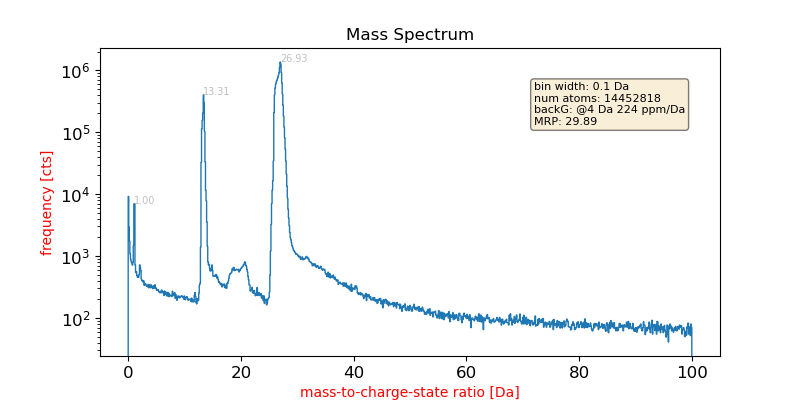

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 20.12711163626445
Peaks  0 is at location and height: (2.81, 4356.00) peak window sides (half-maximum) are: (2.61, 2.91)
Peaks  1 is at location and height: (17.72, 121279.00) peak window sides (half-maximum) are: (17.12, 18.12)
Peaks  2 is at location and height: (32.23, 734294.00) peak window sides (half-maximum) are: (31.33, 32.94)
Peaks  3 is at location and height: (52.65, 198.00) peak window sides (half-maximum) are: (52.55, 52.85)


In [122]:
percent_mrp = 50
peak_p, peaks_y_p, peak_widths_p = tools.hist_plot(mc_p_1[mc_p_1 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=percent_mrp, plot=True, fig_name='mc2_p_1'+figname)
index_max_ini = np.argmax(peaks_y_p)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [123]:
data['t_c (ns)'] = variables.dld_t_calib
data['mc_c (Da)'] = mc_p_1

In [124]:
# Remove negative mc
threshold = 0
mc_t = data['mc_c (Da)'].to_numpy()
mc_t_mask = (mc_t <= threshold)
data.drop(np.where(mc_t_mask)[0], inplace=True)
data.reset_index(inplace=True, drop=True)

In [125]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp,t_c (ns)
0,0.0,0.0,0.0,28.415732,26.453897,3673.539062,3673.539062,34535.0,725.110056,0.0,0.614449,-0.041388,0,1,732.611167
1,0.0,0.0,0.0,28.219432,26.323777,3673.539062,3673.539062,34593.0,725.315796,0.0,0.725878,0.725878,58,1,730.362400
2,0.0,0.0,0.0,28.425506,26.516879,3673.539062,3673.539062,34604.0,727.777818,0.0,0.684490,0.764082,11,1,732.722938
3,0.0,0.0,0.0,28.037984,26.214062,3673.539062,3673.539062,34939.0,721.180422,0.0,0.159184,0.197388,335,1,728.276805
4,0.0,0.0,0.0,27.851413,25.671665,3673.539062,3673.539062,35190.0,727.448634,0.0,0.369306,-2.193551,251,1,726.125289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951764,0.0,0.0,0.0,1174.540893,1145.049275,7540.238770,7540.238770,1246.0,3284.707680,0.0,3.311020,0.846857,180,1,4261.143134
14951765,0.0,0.0,0.0,26.026364,26.755073,7540.238770,7540.238770,1491.0,525.501108,0.0,0.967837,-0.038204,245,1,704.686581
14951766,0.0,0.0,0.0,26.107464,26.706144,7540.238770,7540.238770,1563.0,533.970738,0.0,-0.350204,-2.333633,72,1,705.654916
14951767,0.0,0.0,0.0,13.020586,13.491915,7540.238770,7540.238770,1700.0,395.734032,0.0,2.534204,-0.248327,137,1,522.632990


In [126]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')

In [127]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data, path=variables.result_path, name=dataset_name + '.POS')

In [128]:
# save data in csv format
data_tools.store_df_to_csv(data, variables.result_path + dataset_name + '.csv')